In [1]:
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data

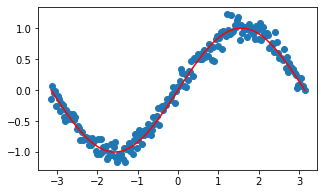

In [2]:
# True data 생성
# -3.14 ~ 3.14 사이의 200개의 난수 생성(train:140, test:60)
N = 200

x = np.linspace(-np.pi, np.pi, N).reshape(-1, 1)

# sin(x)
sin = np.sin(x)
y = sin + 0.1*np.random.randn(N, 1) # sin 그래프에 Gaussian noise를 추가

# sin 그래프
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(x, sin, color='red')

ax.scatter(x, y)

plt.show()

In [3]:
# feature 생성
n_feature = 5

PHI = np.ones(shape=(N, 1))

for i in range(1, n_feature):
    PHI = np.concatenate([PHI, np.power(x, i)], axis=1)
    
print(f"shape of PHI: {PHI.shape}")
print(f"데이터 개수: {PHI.shape[0]}")
print(f"feature 개수: {PHI.shape[1]}")

shape of PHI: (200, 5)
데이터 개수: 200
feature 개수: 5


In [4]:
# shuffle data
np.random.seed(2022)

idx = np.random.permutation(N)
shuffle_x = x[idx]
shuffle_PHI = PHI[idx]
shuffle_y = y[idx]

num_train = 140

# train data
x_train = shuffle_x[:num_train]
PHI_train = shuffle_PHI[:num_train]
y_train = shuffle_y[:num_train]

# test data
x_test = shuffle_x[num_train:]
PHI_test = shuffle_PHI[num_train:]
y_test = shuffle_y[num_train:]

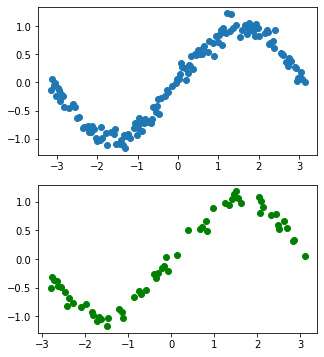

In [5]:
# train, test 그래프
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

axes[0].scatter(x_train, y_train)
axes[1].scatter(x_test, y_test, color='green')

plt.show()

In [6]:
# make data to tensor
ts_whole_x = torch.tensor(PHI, dtype=torch.float)

ts_train_x = torch.tensor(PHI_train, dtype=torch.float)
ts_train_y = torch.tensor(y_train, dtype=torch.float)

ts_test_x = torch.tensor(PHI_test, dtype=torch.float)
ts_test_y = torch.tensor(y_test, dtype=torch.float)

## Model

In [7]:
class ANN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(ANN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, 64)
        self.fc2 = torch.nn.Linear(64, 64)    # hidden layer1
        self.fc3 = torch.nn.Linear(64, 64)    # hidden layer2
        self.fc4 = torch.nn.Linear(64, 64)    # hidden layer3
        self.fc5 = torch.nn.Linear(64, 64)    # hidden layer4
        self.fc6 = torch.nn.Linear(64, 64)    # hidden layer5
        self.fc7 = torch.nn.Linear(64, 16)    # hidden layer6
        self.fc8 = torch.nn.Linear(16, self.output_size)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        return x

input_dim = 5
output_dim = 1
model = ANN(input_dim, output_dim)

## SGD

In [8]:
# 손실함수
loss_function = torch.nn.MSELoss()
# Optimizer = SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Training

In [9]:
train_loss_list = []
test_loss_list = []
num_epoch = 500

for epoch in range(num_epoch):
    model.train()
    optimizer.zero_grad()
    
    prediction = model(ts_train_x)
    loss = loss_function(prediction, ts_train_y)
    
    loss.backward()
    optimizer.step()
    train_loss_list.append(loss.item())
    
    # Validation
    with torch.no_grad():
        test_prediction = model(ts_test_x)
        test_loss = loss_function(test_prediction, ts_test_y)
        test_loss_list.append(test_loss)
        
    if (epoch+1) % 20 == 0:
        print(f"Epoch[{epoch+1}], train_loss: {train_loss_list[-1]}, test_loss: {test_loss_list[-1]}")

Epoch[20], train_loss: 0.08063694834709167, test_loss: 0.06038409471511841
Epoch[40], train_loss: 0.019233712926506996, test_loss: 0.01872503012418747
Epoch[60], train_loss: 0.013757489621639252, test_loss: 0.016970859840512276
Epoch[80], train_loss: 0.012748598121106625, test_loss: 0.01568415015935898
Epoch[100], train_loss: 0.01571817137300968, test_loss: 0.018603293225169182
Epoch[120], train_loss: 0.01924985647201538, test_loss: 0.023795416578650475
Epoch[140], train_loss: 0.016524100676178932, test_loss: 0.020376505330204964
Epoch[160], train_loss: 0.016394024714827538, test_loss: 0.020007772371172905
Epoch[180], train_loss: 0.01632537506520748, test_loss: 0.01986142247915268
Epoch[200], train_loss: 0.01610315777361393, test_loss: 0.01948138140141964
Epoch[220], train_loss: 0.016022535040974617, test_loss: 0.019169913604855537
Epoch[240], train_loss: 0.01587751880288124, test_loss: 0.018950223922729492
Epoch[260], train_loss: 0.015642281621694565, test_loss: 0.018692145124077797
E

### Visualization

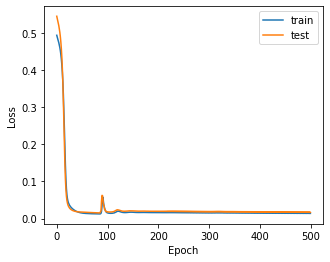

In [10]:
# Loss값 확인
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(train_loss_list, label='train')
ax.plot(test_loss_list, label='test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()

plt.show()

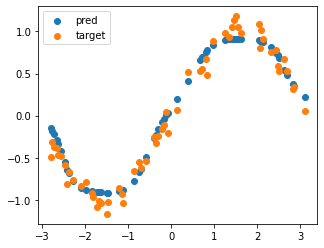

In [11]:
# Test data 확인
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(x_test, test_prediction, label='pred')
ax.scatter(x_test, y_test, label='target')

ax.legend()

plt.show()

## Adam

In [12]:
model = ANN(input_dim, output_dim)

# 손실함수
loss_function = torch.nn.MSELoss()
# Optimizer = Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [13]:
train_loss_list = []
test_loss_list = []
num_epoch = 500

for epoch in range(num_epoch):
    model.train()
    optimizer.zero_grad()
    
    prediction = model(ts_train_x)
    loss = loss_function(prediction, ts_train_y)
    
    loss.backward()
    optimizer.step()
    train_loss_list.append(loss.item())
    
    # Validation
    with torch.no_grad():
        test_prediction = model(ts_test_x)
        test_loss = loss_function(test_prediction, ts_test_y)
        test_loss_list.append(test_loss)
        
    if (epoch+1) % 20 == 0:
        print(f"Epoch[{epoch+1}], train_loss: {train_loss_list[-1]}, test_loss: {test_loss_list[-1]}")

Epoch[20], train_loss: 0.07023948431015015, test_loss: 0.054595015943050385
Epoch[40], train_loss: 0.030063161626458168, test_loss: 0.031064650043845177
Epoch[60], train_loss: 0.014070456847548485, test_loss: 0.017136134207248688
Epoch[80], train_loss: 0.012141752988100052, test_loss: 0.015556496568024158
Epoch[100], train_loss: 0.011501036584377289, test_loss: 0.014162999577820301
Epoch[120], train_loss: 0.01100850012153387, test_loss: 0.013593757525086403
Epoch[140], train_loss: 0.010758821852505207, test_loss: 0.013145318254828453
Epoch[160], train_loss: 0.010617162100970745, test_loss: 0.012814857997000217
Epoch[180], train_loss: 0.010506520047783852, test_loss: 0.0125597408041358
Epoch[200], train_loss: 0.010407465510070324, test_loss: 0.012318537570536137
Epoch[220], train_loss: 0.010314226150512695, test_loss: 0.01209293957799673
Epoch[240], train_loss: 0.010224669240415096, test_loss: 0.011875583790242672
Epoch[260], train_loss: 0.010137970559298992, test_loss: 0.01166297309100

### Visualization

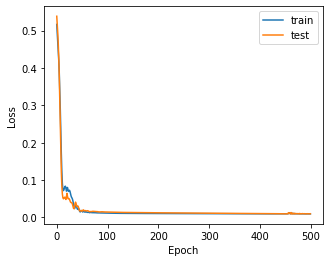

In [14]:
# Loss값 확인
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(train_loss_list, label='train')
ax.plot(test_loss_list, label='test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()

plt.show()

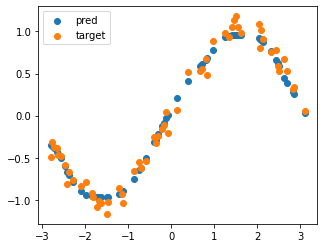

In [15]:
# Test data 확인
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(x_test, test_prediction, label='pred')
ax.scatter(x_test, y_test, label='target')

ax.legend()

plt.show()